In [1]:
import numpy as np
from numpy import random
from random import choices
import matplotlib.pyplot as plt
import levy
# import plotly.express as px

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

In [342]:
class Bandits:
    def __init__(self,total_time):
        self.options = 4            # Number of options
        self.sigma = 4              # Variance of sampled payoff from option
        self.decay = 0.9836         # Decay constant of expected payoff RW
        self.decay_centre = 50      # Decay centre of expected payoff RW
        self.sigma_noise = 2.8      # Variance of expected payoff RW
        self.time = total_time      # Total simulation time

    def sample(self,mu):
        # Sample from input mean and constant variance
        return random.normal(mu,self.sigma)
    
    def genMeans(self,starting_var):
        # Generate the mean payoff according to a decaying Gaussian random walk (what is decaying?)
        noise = random.normal(0,self.sigma_noise,(self.options,self.time))   # Preallocating Gaussian noise for payoff diffusion
        payoff0 = np.round(random.normal(50,starting_var,(self.options,1)))            # Defining expected payoffs for step 1
        payoff = np.zeros([self.options,self.time])                          # Preallocating payoff walker
        payoff[:,0] = np.transpose(payoff0)
        for t in range(1,self.time):        # Loop over time and generate expected payoff RW
            payoff[:,t] = self.decay*payoff[:,t-1] + (1-self.decay) * self.decay_centre + noise[:,t]
        return payoff

    def findRegret(self,payoff,result):
        optimal_scores = np.zeros(self.time)
        for t in range(self.time):
            chosen = np.argmax(payoff[:,t])
            # optimal_scores[t] = self.sample(payoff[chosen,t])
            optimal_scores[t] = payoff[chosen,t]
        regret = 1 - result/sum(optimal_scores)
        return regret, optimal_scores

    def exploit(self,payoff,trials):
        scores = np.zeros([trials,self.time])                               # Initialise score history
        scores[:,range(4)] = [self.sample(payoff[range(4),0]) for _ in range(trials)]     # Sample from each option once
        chosen = np.argmax(scores,1)
        for t in range(4,total_time):
            scores[:,t] = self.sample(payoff[chosen,t])
        return np.sum(scores,1)


In [309]:
trials = 7
scores = np.zeros([trials,20])
scores[:,range(4)] = [simu.sample(payoffs[range(4),0]) for _ in range(trials)]
chosen = np.argmax(scores,1)
for t in range(4,20):
    scores[:,t] = simu.sample(payoffs[chosen,t])
np.sum(scores,1)


array([1596.32103763, 1543.58148635, 1529.11541685, 1554.28733186,
       1547.65861922, 1537.11464036, 1539.53229934])

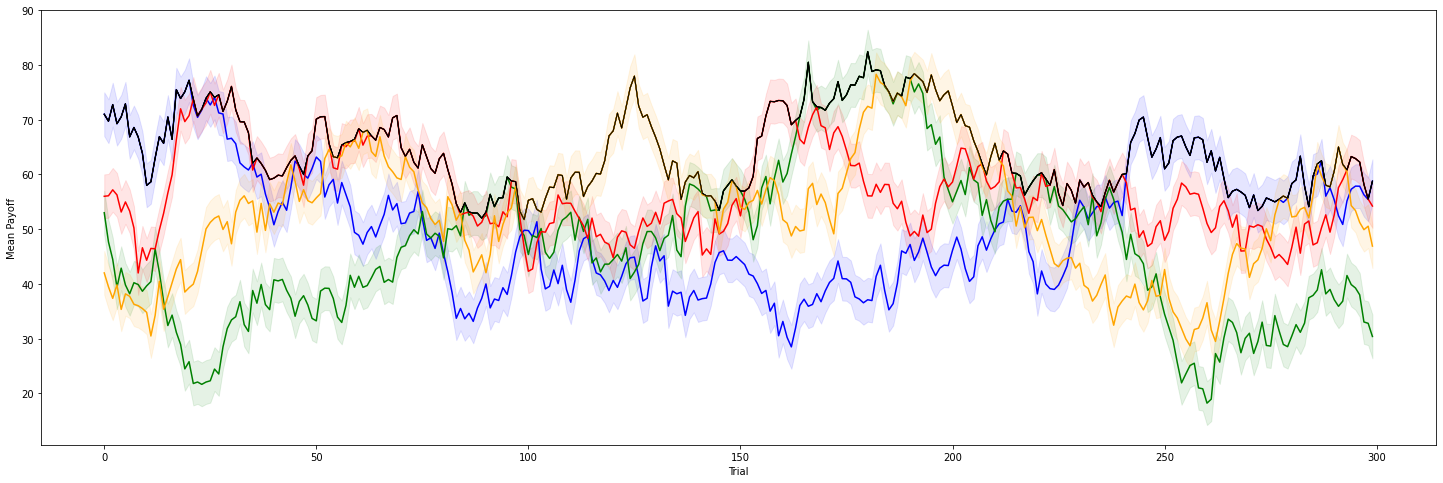

In [360]:
total_time = 300
simu = Bandits(total_time)
payoffs = simu.genMeans(10)
[_, optimal_scores] = simu.findRegret(payoffs,0)


# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:],color=colors[i])                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
    plt.plot(range(total_time),optimal_scores,linewidth=1,color='black')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.show()

In [357]:
exploit_reward = simu.exploit(payoffs,10000)
[regret_exploit, _] = simu.findRegret(payoffs,exploit_reward)

print('Pure exploitation Mean Regret: %s'% np.mean(regret_exploit))


Pure exploitation Mean Regret: 0.17977064104957147


In [216]:
simu.exploit()

AttributeError: 'Bandits' object has no attribute 'candidates'